In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Cuda is not available. Training on CPU...')
else:
    print('Cuda is available! Training on GPU...')


Cuda is available! Training on GPU...


In [3]:
num_workers = 0
batch_size = 64
valid_size = 0.2

transform = transforms.ToTensor()

train_data = torchvision.datasets.EMNIST(
    root='data', split='byclass', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.EMNIST(
    root='data', split='byclass', train=False, download=True, transform=transform
)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

classes = train_data.classes

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc_bn2 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(in_features=512, out_features=62)
        
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        x = x.view(-1, 256 * 3 * 3)
        
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)
        
        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)
        
        x = self.fc3(x)
        
        return x

model = Net()
print("\n--- Model Architecture ---")
print(model)

if train_on_gpu:
  model.cuda()


--- Model Architecture ---
Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): 

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model, you decide the number
n_epochs = 15

valid_loss_min = np.inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss
    else:
        print('Validation loss has not decreased. Ending training')
        break

KeyboardInterrupt: 

In [7]:
model.load_state_dict(torch.load('./model_trained.pt'))

<All keys matched successfully>

In [8]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(62))
class_total = list(0. for i in range(62))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.321291

Test Accuracy of     0: 79% (4607/5778)
Test Accuracy of     1: 91% (5762/6330)
Test Accuracy of     2: 98% (5768/5869)
Test Accuracy of     3: 99% (5944/5969)
Test Accuracy of     4: 98% (5550/5619)
Test Accuracy of     5: 93% (4869/5190)
Test Accuracy of     6: 98% (5622/5705)
Test Accuracy of     7: 99% (6123/6139)
Test Accuracy of     8: 99% (5583/5633)
Test Accuracy of     9: 98% (5583/5686)
Test Accuracy of     A: 98% (1047/1062)
Test Accuracy of     B: 98% (638/648)
Test Accuracy of     C: 97% (1695/1739)
Test Accuracy of     D: 91% (709/779)
Test Accuracy of     E: 99% (844/851)
Test Accuracy of     F: 97% (1402/1440)
Test Accuracy of     G: 89% (398/447)
Test Accuracy of     H: 97% (509/521)
Test Accuracy of     I: 54% (1109/2048)
Test Accuracy of     J: 88% (555/626)
Test Accuracy of     K: 83% (319/382)
Test Accuracy of     L: 96% (780/810)
Test Accuracy of     M: 99% (1478/1485)
Test Accuracy of     N: 98% (1331/1351)
Test Accuracy of     O: 60% (2527/4

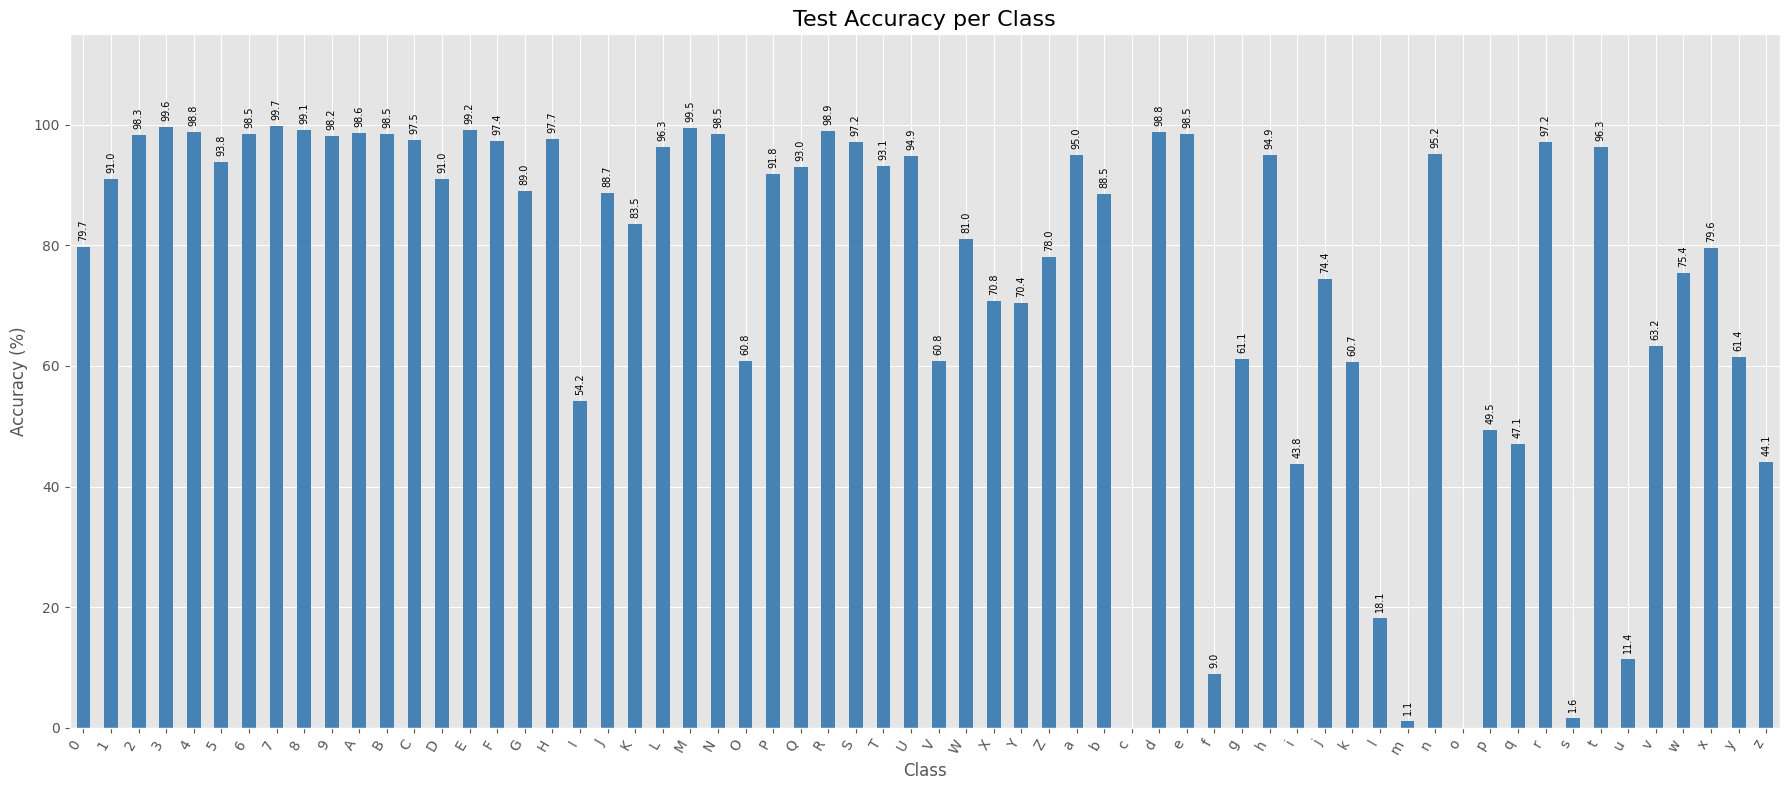

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

digits = [str(i) for i in range(10)]
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]
classes = digits + uppercase + lowercase

accuracies = [100 * (c / t) if t > 0 else 0 for c, t in zip(class_correct, class_total)]

df = pd.DataFrame({
    'Class': classes,
    'Accuracy': accuracies
})

# df = df.sort_values(by='Accuracy', ascending=False)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18, 8))

df.plot(kind='bar', x='Class', y='Accuracy', ax=ax, color='steelblue', legend=False)

ax.set_title('Test Accuracy per Class', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel('Class', fontsize=12)

plt.xticks(rotation=60, ha='right')

for index, value in enumerate(df['Accuracy']):
    if value > 0:
        ax.text(index, value + 1, f"{value:.1f}", ha='center', va='bottom', fontsize=7, rotation=90)

plt.ylim(0, 115)
plt.tight_layout()
plt.show()

In [94]:
import random
import string

def generate_random_chars(length=15, separator=' '):
    pool = string.digits + string.ascii_lowercase + string.ascii_uppercase
    chars = random.choices(pool, k=length)
    return separator.join(chars)

generate_random_chars()

'9 W 4 k 5 z O x b Q I 8 a d Y'

In [ ]:
import pygame
import sys
from PIL import Image
import matplotlib.pyplot as plt
import torch

CHARACTER_MAP = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]

pygame.init()

WIDTH, HEIGHT = 250, 250
LINE_WIDTH = 15
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Draw a Character (ENTER to predict, C to clear)")

drawing = False
running = True
screen.fill(BLACK)

while running:
  for event in pygame.event.get():
    if event.type == pygame.QUIT:
      running = False

    elif event.type == pygame.MOUSEBUTTONDOWN:
      drawing = True
      pygame.draw.circle(screen, WHITE, event.pos, LINE_WIDTH // 2)

    elif event.type == pygame.MOUSEBUTTONUP:
      drawing = False

    elif event.type == pygame.MOUSEMOTION:
      if drawing:
        pygame.draw.circle(screen, WHITE, event.pos, LINE_WIDTH // 2)

    elif event.type == pygame.KEYDOWN:
      if event.key == pygame.K_c:
        screen.fill(BLACK)
        pygame.display.set_caption("Draw a Character (ENTER to predict, C to clear)")
      if event.key == pygame.K_q:
        running = False

      if event.key == pygame.K_RETURN:
        try:
          pixel_data = pygame.surfarray.array3d(screen)
          pil_image = Image.fromarray(pixel_data.transpose(1, 0, 2)).convert('L')
          resized_image = pil_image.resize((28, 28))

          rotated_image = resized_image.rotate(-90, resample=Image.BICUBIC)
          flipped_image = rotated_image.transpose(Image.FLIP_LEFT_RIGHT)

          image_tensor = transform(flipped_image).unsqueeze(0)
          model.eval()
          if train_on_gpu:
            image_tensor = image_tensor.cuda()

          with torch.no_grad():
            output = model(image_tensor)
            _, pred = torch.max(output, 1)
            prediction_index = pred.item()

            if 0 <= prediction_index < len(CHARACTER_MAP):
                prediction_char = CHARACTER_MAP[prediction_index]
            else:
                prediction_char = '?'

          print(f'--- Prediction: {prediction_char} (index: {prediction_index}) ---')
          pygame.display.set_caption(f"Prediction: {prediction_char} (Press C to clear)")

        except Exception as e:
          print(f"An error occurred during prediction: {e}")

  pygame.display.flip()

pygame.quit()

--- Prediction: a (index: 36) ---
--- Prediction: 2 (index: 2) ---
